In [22]:
%%capture --no-stderr
%pip install --quiet -U langchain_core langgraph langchain_google_genai serpapi tavily-python langchain_community

In [23]:
from google.colab import userdata
google_api_key = userdata.get('GEMINI_API_KEY')


In [24]:
import os
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "langchain-academy"
os.environ["TAVILY_API_KEY"] = userdata.get("TAVILY_API_KEY")

In [25]:
from langchain_google_genai import ChatGoogleGenerativeAI
llm: ChatGoogleGenerativeAI = ChatGoogleGenerativeAI(model="gemini-1.5-flash", api_key=google_api_key)


In [26]:
from langgraph.graph import MessagesState
from typing import TypedDict, List, Annotated, Union
class AgentState(MessagesState):
    # messages: Annotated[List[Union[HumanMessage, AIMessage, SystemMessage]], operator.add]
    budget: float
    interests: List[str]
    companions: int
    city: str
    days: int
    travel_date: str
    itinerary: List[dict]  # To store the final itinerary


In [27]:
def get_system_prompt(state: AgentState):
    return f"""You are a smart travel assistant. Create a detailed itinerary considering:
    - Budget: ${state['budget']}
    - Travel Interests: {', '.join(state['interests'])}
    - Companions: {state['companions']} people
    - Destination: {state['city']}
    - Duration: {state['days']} days
    - Travel Date: {state['travel_date']}

    Include daily:
    - Hotels with prices and links
    - Transportation options
    - Food recommendations
    - Activities with costs
    - Total estimated daily cost
    Provide hotel logos when possible."""


In [28]:
# from langchain_core.tools import tool

# from typing import Optional

# from pydantic import BaseModel, Field
# import serpapi
# # from langchain.pydantic_v1 import BaseModel, Field
# from langchain_core.tools import tool

# class HotelsInput(BaseModel):
#     q: str = Field(description='Location of the hotel')
#     check_in_date: str = Field(description='Check-in date. The format is YYYY-MM-DD. e.g. 2024-06-22')
#     check_out_date: str = Field(description='Check-out date. The format is YYYY-MM-DD. e.g. 2024-06-28')
#     sort_by: Optional[str] = Field(8, description='Parameter is used for sorting the results. Default is sort by highest rating')
#     adults: Optional[int] = Field(1, description='Number of adults. Default to 1.')
#     children: Optional[int] = Field(0, description='Number of children. Default to 0.')
#     rooms: Optional[int] = Field(1, description='Number of rooms. Default to 1.')
#     hotel_class: Optional[str] = Field(
#         None, description='Parameter defines to include only certain hotel class in the results. for example- 2,3,4')


# class HotelsInputSchema(BaseModel):
#     params: HotelsInput


# @tool(args_schema=HotelsInputSchema)
# def hotels_finder(params: HotelsInput):
#     '''
#     Find hotels using the Google Hotels engine.

#     Returns:
#         dict: Hotel search results.
#     '''

#     params = {
#         'api_key': os.environ.get('SERPAPI_API_KEY'),
#         'engine': 'google_hotels',
#         'hl': 'en',
#         'gl': 'us',
#         'q': params.q,
#         'check_in_date': params.check_in_date,
#         'check_out_date': params.check_out_date,
#         'currency': 'USD',
#         'adults': params.adults,
#         'children': params.children,
#         'rooms': params.rooms,
#         'sort_by': params.sort_by,
#         'hotel_class': params.hotel_class
#     }

#     search = serpapi.search(params)
#     results = search.data
#     return results['properties'][:5]
from langchain_community.tools.tavily_search import TavilySearchResults
from pydantic import BaseModel



tool = TavilySearchResults(max_results=2)
tools = [tool]


In [29]:
# tools: list[tool] = [hotels_finder]
llm: ChatGoogleGenerativeAI = ChatGoogleGenerativeAI(model = "gemini-1.5-flash")
# llm_with_tools = llm.bind_tools(tools)
llm_with_tools = llm.bind_tools(tools)

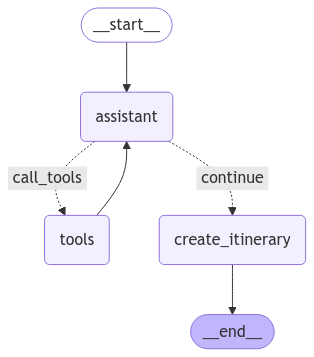

In [30]:
from langchain_core.messages import AIMessage, HumanMessage, SystemMessage,ToolMessage
from langgraph.prebuilt import tools_condition, ToolNode
from langgraph.graph import StateGraph, END ,START
from IPython.display import display, Image
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph.state import CompiledStateGraph

def assistant(state: AgentState):
    system_prompt = SystemMessage(content=get_system_prompt(state))
    messages = [system_prompt] + state['messages']
    response = llm_with_tools.invoke(messages)
    return {"messages": [response]}

# New itinerary creation node
def create_itinerary(state: AgentState):
    # Parse tool responses and format itinerary
    itinerary = []
    tool_results = [msg.content for msg in state['messages'] if isinstance(msg, ToolMessage)]

    # Create structured itinerary (simplified example)
    itinerary_entry = {
        "city": state['city'],
        "days": state['days'],
        "daily_plan": [],
        "total_estimated_cost": state['budget']
    }

    # Add parsed tool data to itinerary
    for result in tool_results:
        if 'hotels' in result:
            itinerary_entry['hotels'] = result['hotels'][:3]  # Top 3 hotels

    return {"itinerary": [itinerary_entry], "messages": [AIMessage(content="Itinerary created!")]}

# Modified graph construction
builder = StateGraph(AgentState)
builder.add_node("assistant", assistant)
builder.add_node("tools", ToolNode([tool]))  # Add other tools as needed
builder.add_node("create_itinerary", create_itinerary)

# Edge connections
builder.add_edge(START, "assistant")
builder.add_conditional_edges(
    "assistant",
    tools_condition,
    {
        "call_tools": "tools",
        "continue": "create_itinerary"
    }
)
builder.add_edge("tools", "assistant")
builder.add_edge("create_itinerary", END)



memory: MemorySaver = MemorySaver()
graph: CompiledStateGraph = builder.compile( checkpointer=memory)

# Show
display(Image(graph.get_graph(xray=True).draw_mermaid_png()))


In [31]:
initial_state = {
    "messages": [HumanMessage(content="Plan my trip")],
    "budget": 5000.0,
    "interests": ["sightseeing", "local cuisine"],
    "companions": 2,
    "city": "Paris",
    "days": 7,
    "travel_date": "2024-09-01",
    "itinerary": []
}


In [34]:
result = graph.invoke(
    initial_state,
    {"configurable": {"thread_id": "123"}}
)